In [1]:
import dedalus_sphere.zernike as Zernike
import dedalus_sphere.jacobi as Jacobi

import numpy as np
import scipy as sp
import scipy.linalg
import scipy.sparse as sparse
import matplotlib.pyplot as plt
%matplotlib notebook

np.set_printoptions(precision=3,suppress=True)

# Add '../' to path
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from kronecker import Kronecker
from stretched_sphere import make_square_resizer, laplacian, laplacian_correction, matrices, zernike_operator
    
# Common operators
dim = 2
Ds = Zernike.operator(dim, 'D')
E = Zernike.operator(dim, 'E')
R = Zernike.operator(dim, 'R')
IdR = Zernike.operator(dim, 'Id')

A = Jacobi.operator('A')
B = Jacobi.operator('B')
C = Jacobi.operator('C')
Dz = Jacobi.operator('D')
Z = Jacobi.operator('Z')
IdZ = Jacobi.operator('Id')

# Composite operators
H = IdR - R(-1) @ R(+1)
# RdR = 1/2*(R(+1) @ Ds(-1) + R(-1) @ Ds(+1))
RdR = zernike_operator(dim, 'RdR')
ZdZ = Z @ Dz(+1)
S2 = R(-1) @ R(+1)
H2 = H**2
Z2 = Z**2
AB = A(+1) @ B(+1)

def plotfield(s, eta, f):
    fig, ax = plt.subplots(figsize=(7,4))
    im = ax.pcolormesh(s, eta, f)
    fig.colorbar(im, ax=ax)
    ax.set_xlabel('s')
    ax.set_ylabel('η')

def expansion(F, T, Q):
    return T @ (Q @ F).T



In [2]:
# Test horizontal part of Laplacian
m, Nmax, Lmax = 0, 10, 8
a, b, k = -1/2, -1/2, 0
neta, ns = 2000, 1000

s, eta = np.linspace(0,1,ns+1)[1:], np.linspace(-1,1,neta)
z = 2*s**2 - 1
Pn = Zernike.polynomials(dim,Nmax,k,m,z).T
Tn = Jacobi.polynomials(Lmax,a,b,eta).T

resizer = make_square_resizer([Nmax, Lmax])
kron = lambda ops, opz: Kronecker([ops, opz], resizer)
kron_params = [(Nmax,k,m),(Lmax,a,b)]

# Constant function
One = np.zeros((Nmax,Lmax))
One[0,0] = 1/(Pn[0,0]*Tn[0,0])

# Construct the test function so that Lap(f) = 6:
#   f = x**2 + y**2 + z**2 = s**2 + (1-s**2)*eta**2
op = kron(S2, IdZ) + kron(H, Z2)
F = np.reshape(op(kron_params) @ One.ravel(), (Nmax,Lmax))
f = expansion(F, Tn, Pn)

# Check the operator did what we wanted
sg, etag = np.reshape(s, (1,ns)), np.reshape(eta, (neta,1))
fgrid = sg**2 + (1 - sg**2) * etag**2
assert np.max(abs(f-fgrid)) < 1e-15

# Expected solution
Lconv = kron(6 * E(+1)**2 @ H2, (A(+1) @ B(+1))**2)
Ltrue = np.reshape(Lconv(kron_params) @ One.ravel(), (Nmax,Lmax))

# (1-s**2)**2 Lap(f)
L = laplacian(resizer)
LF = np.reshape(L(kron_params) @ F.ravel(), (Nmax,Lmax))
assert np.max(abs(LF-Ltrue)) < 1e-15

Pn = Zernike.polynomials(dim,Nmax,k+2,m,z).T
Tn = Jacobi.polynomials(Lmax,a+2,b+2,eta).T
lf = expansion(LF, Tn, Pn)
lfgrid = 6 * (1 - sg**2)**2 + 0*etag
assert np.max(abs(lf-lfgrid)) < 1e-14



# Boundary Conditions

## No-Slip
The no-slip boundary condition requires velocity vector $(u,v,w)$ to vanish identically on the surface of the ball.  This is at coordinate $\eta = \pm 1$ hence we require the vertical part of the expansion to vanish identically there.  That is, for our expansion given by
$$ f_m(s,\eta) = \sum_n \sum_n F_{n,l}^m P_n^{k,m}(s) T_{l}(\eta) e^{i m \phi} $$
we require
$$ f_m(s,\pm 1) = \sum_n \sum_l F_{n,l}^m P_n^{k,m}(s) T_{l}(\pm 1) e^{i m \phi} = 0 
    \implies \sum_l F_{n,l}^m T_{l}(\pm 1) = 0 \hspace{2ex}\text{ for all } n,m $$
We apply the boundary conditions by fixing $n$ and using the $z=+1$ and $z=-1$ operators to generate a length-$L_{\text{max}}$ row vector.  This is then broadcast out into the matrix using a Kronecker product.

/opt/miniconda3/envs/dedalus/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


<IPython.core.display.Javascript object>


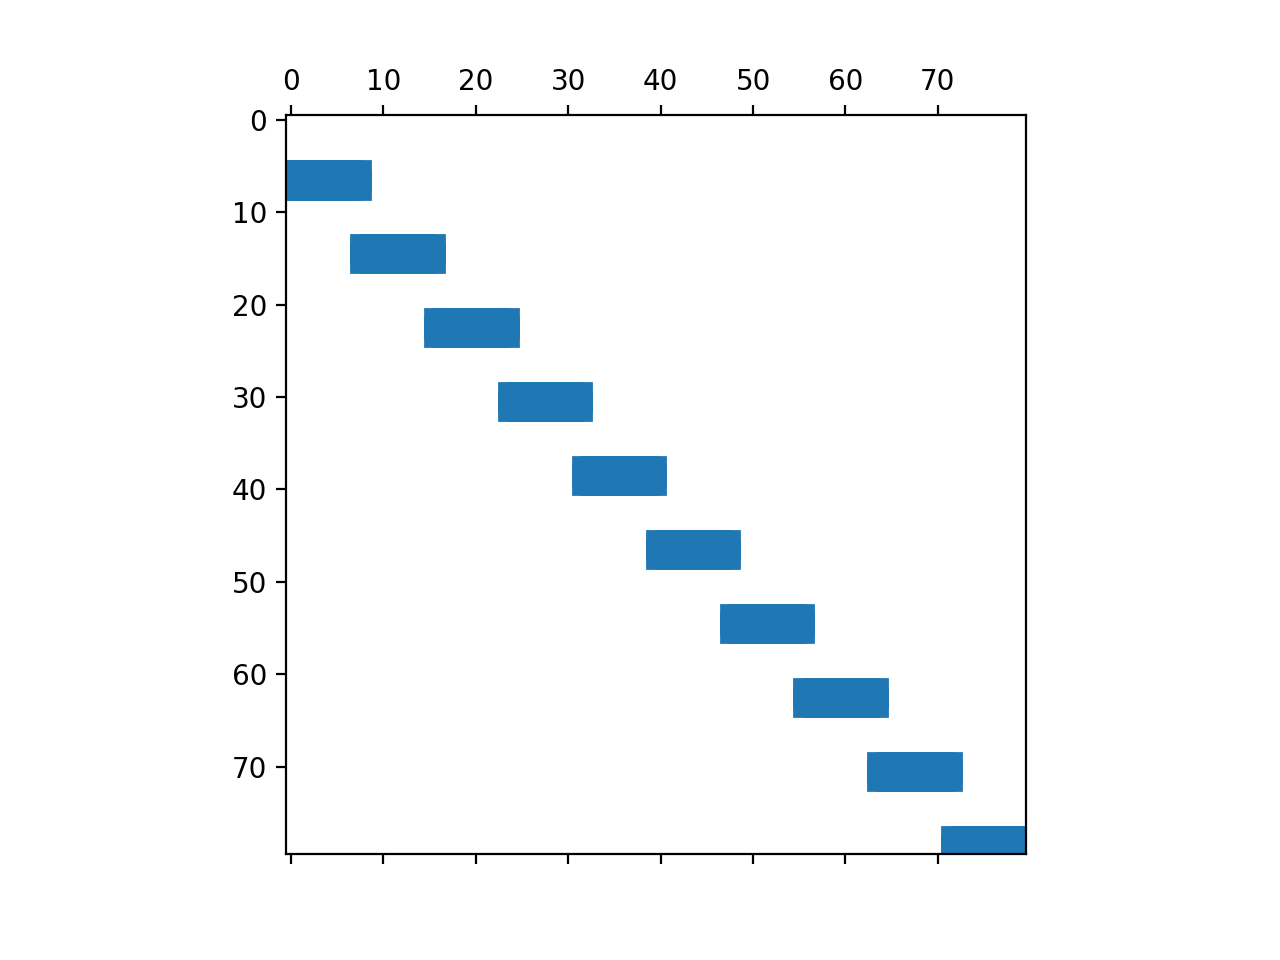

In [3]:
Nmax, k, m = 10, 0, 9
Lmax, a, b = 8, -1/2, -1/2
Ekman, Prandtl, Rayleigh = 10**-4.5, 1, 4.7613
boundary_condition = 'no-slip'

# Marti/Jones scaling
Rayleigh /= Ekman**(1/3)

# Construct the system
M, L = matrices(Nmax, k, m, Lmax, a, b, Ekman, Prandtl, Rayleigh, boundary_condition)

# Boundary condition operators
bc_row_left = Jacobi.polynomials(Lmax,a,b,-1)
bc_row_right = Jacobi.polynomials(Lmax,a,b,1)
bc_mat_1d = sparse.vstack([np.zeros((Lmax-2,Lmax)), bc_row_left, bc_row_right])

# Kronecker the boundary condition operators into the full matrix
bc_rows, bc_cols, bc_vals = [], [], []
for n in range(Nmax):
    Idn = np.zeros((Nmax,Nmax)); Idn[n,n] = 1
    bc_mat_2d = sparse.kron(Idn, bc_mat_1d, format='csr')
    rows, cols = bc_mat_2d.nonzero()
    
    bc_rows += rows.tolist()
    bc_cols += cols.tolist()
    bc_vals += [bc_mat_2d[rows[i],cols[i]] for i in range(2*Lmax)]
bc_mat = sparse.csr_matrix((bc_vals, (bc_rows, bc_cols)), shape=(Nmax*Lmax,Nmax*Lmax))

plt.spy(bc_mat)


